In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score

from lbl2vec import Lbl2Vec, Lbl2TransformerVec

from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags

import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

In [2]:
def get_assignment_lbl2vec_on_dataset(dataset_name: str, n_iterations: int = 10, n_words: int = 20):
    def tokenize(doc):
        return simple_preprocess(strip_tags(doc), deacc=True, min_len=2, max_len=15)
    
    # -- Documents
    documents_df = pd.read_csv(f'../datasets/data/{dataset_name}/documents.csv')
    documents_df['tagged_docs'] = documents_df.apply(
        lambda row: TaggedDocument(tokenize(row['document']), [str(row.name)]), axis=1
    )
    documents_df['doc_key'] = documents_df.index.astype(str)

    # -- Labels
    labels_df = pd.read_csv(f'../datasets/data/{dataset_name}/labels.csv')
    labels_df['number_of_keywords'] = labels_df['class_keywords'].apply(lambda keywords: len(keywords))

    keywords_cached_df = pd.read_csv(f'cache/{dataset_name}_spacy_keywords.csv')
    keywords_cached_df['class_result_keywords'] = keywords_cached_df['class_result_keywords'].apply(lambda x: x[1:-1].replace("'", '').split(', '))
    similar_keywords = dict(zip(keywords_cached_df['class_raw_keywords'], keywords_cached_df['class_result_keywords']))
    labels_df['class_result_keywords'] = labels_df.apply(
        lambda row: similar_keywords[row['class_keywords']][:n_words], axis=1
    )
    documents_df['class_keywords'] = documents_df['class_name'].apply(lambda class_name: labels_df[labels_df['class_name'] == class_name]['class_keywords'].values[0])

    # -- Evaluation
    train_assignment_proba = []
    test_assignment_proba = []

    for i in range(n_iterations):
        print(f'[INFO] {dataset_name} | Iteration {i+1}/{n_iterations}...' + ' ' * 20, end='\r')

         # -- Model
        lbl2vec_model = Lbl2Vec(
            keywords_list=[item for item in labels_df['class_result_keywords']], 
            tagged_documents=list(documents_df['tagged_docs'][documents_df['dataset_type'] == 'train']), 
            label_names=[item for item in labels_df['class_keywords']], 
            min_count=2,
            verbose=False
        )
        lbl2vec_model.fit()

        train_docs_lbl_similarities = lbl2vec_model.predict_model_docs()
        test_docs_lbl_similarities = lbl2vec_model.predict_new_docs(tagged_docs=documents_df['tagged_docs'][documents_df['dataset_type'] == 'test'])

        evaluation_train = train_docs_lbl_similarities.merge(documents_df[documents_df['dataset_type']=='train'], left_on='doc_key', right_on='doc_key')
        evaluation_test = test_docs_lbl_similarities.merge(documents_df[documents_df['dataset_type']=='test'], left_on='doc_key', right_on='doc_key')

        train_assignment_proba.append(evaluation_train['highest_similarity_score'])
        test_assignment_proba.append(evaluation_test['highest_similarity_score'])

    train_assignment_proba = pd.concat(train_assignment_proba, axis=1).mean(axis=1)
    test_assignment_proba = pd.concat(test_assignment_proba, axis=1).mean(axis=1)
    
    return train_assignment_proba, test_assignment_proba

In [3]:
train_assignment_proba_datasets = {}
test_assignment_proba_datasets = {}

for dataset_name in ['BBC_News', '20NewsGroup', 'DBLP', 'M10']:
    train_assignment_proba, test_assignment_proba = get_assignment_lbl2vec_on_dataset(dataset_name, n_iterations=10, n_words=20)

    train_assignment_proba_datasets[dataset_name] = train_assignment_proba
    test_assignment_proba_datasets[dataset_name] = test_assignment_proba

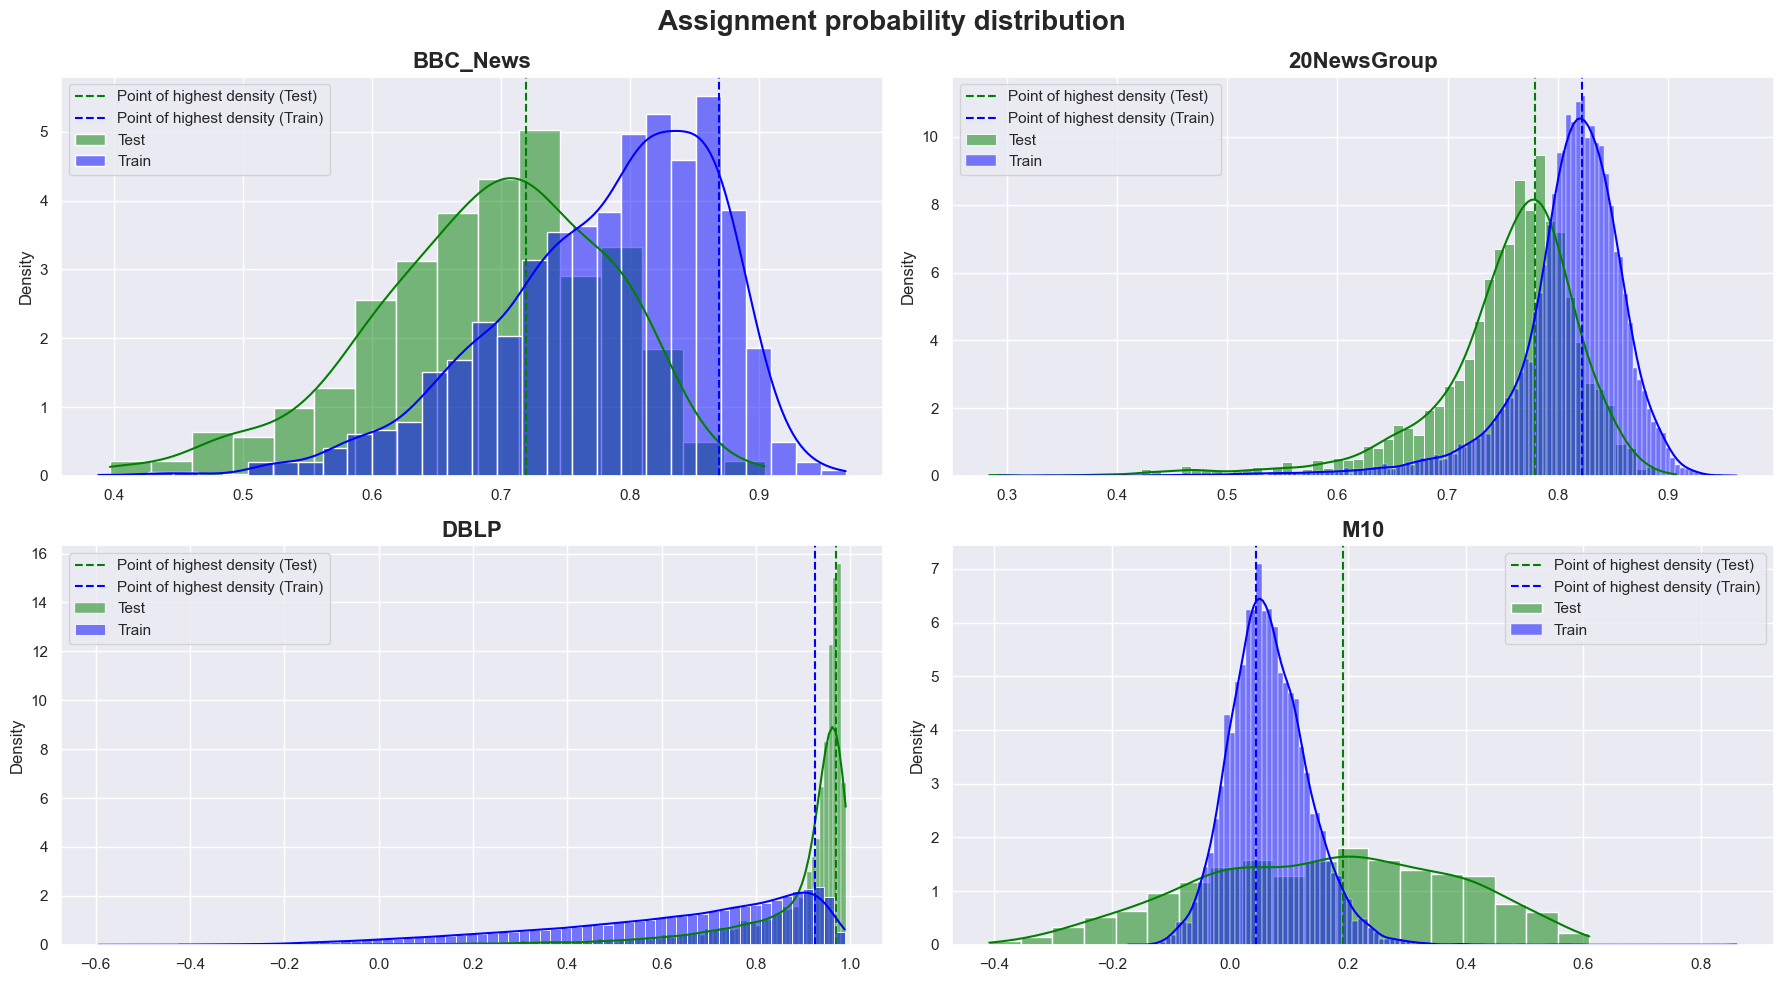

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(18, 10))

x, y = 0, 0

for i, dataset_name in enumerate(['BBC_News', '20NewsGroup', 'DBLP', 'M10']):
    test_hist = np.histogram(test_assignment_proba_datasets[dataset_name], bins=200, density=True)
    test_max_x = test_hist[1][np.argmax(test_hist[0])]

    sns.histplot(test_assignment_proba_datasets[dataset_name], ax=ax[x, y], label='Test', kde=True, stat='density', color='green')
    ax[x, y].axvline(test_max_x, color='green', linestyle='--', label=f'Point of highest density (Test)')

    train_hist = np.histogram(train_assignment_proba_datasets[dataset_name], bins=200, density=True)
    train_max_x = train_hist[1][np.argmax(train_hist[0])]

    sns.histplot(train_assignment_proba_datasets[dataset_name], ax=ax[x, y], label='Train', kde=True, stat='density', color='blue')
    ax[x, y].axvline(train_max_x, color='blue', linestyle='--', label=f'Point of highest density (Train)')

    ax[x, y].set_title(f'{dataset_name}', fontsize=16, fontweight='bold')
    ax[x, y].legend()

    if y == 0:
        y = 1
    else:
        y = 0
        x = 1

fig.suptitle('Assignment probability distribution', fontsize=20, fontweight='bold')
fig.tight_layout()
fig.savefig('../figures/assignment_probability.png', dpi=300)